In [55]:
import numpy as np 
import cv2
import glob
import os
import matplotlib.pyplot as plt
import pickle
import random
import string
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC

In [57]:
datadir = "C:/Users/janna/OneDrive - University Of Houston/Desktop/One Drive Doc/UH/Spring '21/Pattern Recognition/Project/My Project/project_data"
categories = ["Covid", "Normal", "Viral Pneumonia"]
data= []

for category in categories:
    path=os.path.join(datadir,category)
    label=categories.index(category)
    
    for img in os.listdir(path):
        imgpath=os.path.join(path,img)
        xray_img=cv2.imread(imgpath,0)
        xray_img=cv2.resize(xray_img,(50,50))
        image=np.array(xray_img).flatten()
    
        data.append([image,label])

print(image.shape)       
#print(len(data))

(2500,)


In [61]:
pick_in=open('projdata1.pickle','wb')
pickle.dump(data,pick_in)
pick_in.close()

In [62]:
pick_in=open('projdata1.pickle','rb')
data=pickle.load(pick_in)
pick_in.close()

In [89]:
random.shuffle(data)
features=[]
labels=[]

for feature, label in data:
    features.append(feature)
    labels.append(label)
    
print(type(features))
print(type(labels))
print(len(features))
m = np.asarray(features)
print(m.shape)
m = m.astype(np.float64)
m -= m.mean()


import torch
ften=torch.tensor(features)
print(ften.shape)

<class 'list'>
<class 'list'>
3600
(3600, 2500)
torch.Size([3600, 2500])


In [90]:
from tensorly.decomposition import robust_pca
low_rank_part, sparse_part = robust_pca(m, reg_E=0.04, learning_rate=1.2, n_iter_max=20)

In [91]:
print(low_rank_part.shape)
print(sparse_part.shape)

(3600, 2500)
(3600, 2500)


In [95]:
pick_in=open('projlowrdat.pickle','wb')
pickle.dump(low_rank_part,pick_in)
pick_in.close()

In [97]:
pick_in=open('projspardat.pickle','wb')
pickle.dump(sparse_part,pick_in)
pick_in.close()

In [105]:
print(type(low_rank_part))
list1 = low_rank_part.tolist()
print(type(list1))
print(len(list1))

<class 'numpy.ndarray'>
<class 'list'>
3600


In [106]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import decomposition

In [115]:
xtrain, xtest, ytrain, ytest=train_test_split(list1,labels, test_size=0.25)
print(len(xtrain))
print(ytrain.shape)
#pca = decomposition.PCA(n_components=10, whiten=True)
#pca.fit(xtrain)

2700


AttributeError: 'list' object has no attribute 'shape'

In [116]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [117]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000], #Regularization parameter
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10] #number of trees in the forest
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10] #regularization 
        }
    }
}

In [118]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(xtrain, ytrain)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.951111,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,random_forest,0.902963,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.911481,{'logisticregression__C': 1}


In [120]:
best_estimators['svm'].score(xtest,ytest)

0.9644444444444444

In [121]:
best_estimators['random_forest'].score(xtest,ytest)

0.9144444444444444

In [122]:
best_estimators['logistic_regression'].score(xtest,ytest)

0.9277777777777778

In [123]:
from sklearn.metrics import confusion_matrix
best_clf = best_estimators['svm']
cm = confusion_matrix(ytest, best_clf.predict(xtest))
cm

array([[281,   0,   5],
       [  4, 290,  10],
       [  3,  10, 297]], dtype=int64)

Text(69.0, 0.5, 'Truth')

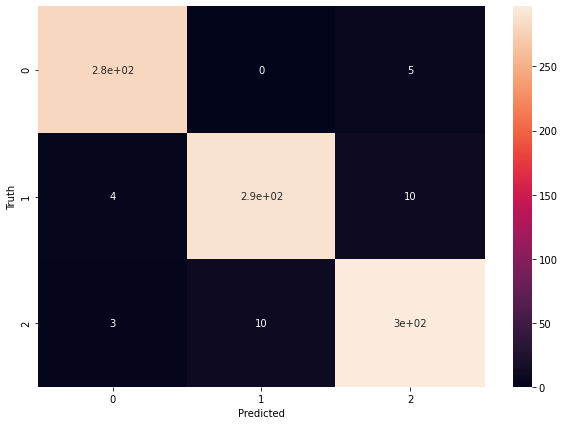

In [124]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')